### Problem Statement
A brain tumor is an abnormal growth of tissue in the brain or central spine that can disrupt proper brain function. Doctors refer to a tumor based on where the tumor cells originated, and whether they are cancerous (malignant) or not (benign)

In this notebook, we will learn how to classify images of brain tumor by using transfer learning from a pre-trained network.

In [7]:
# Importing required packages
import os
import PIL
import cv2
import glob
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, 
                          AveragePooling2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D) 

In [76]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define data directory
data_dir = 'brain_tumor_dataset'
data_dir =pathlib.Path(data_dir)

In [6]:
# Get total number of images
total_images = glob.glob('brain_tumor_dataset/*/*.JPG')
len(total_images)

245

In [14]:
# Creating dataframe
total_images = pd.Series(total_images)

total_df = pd.DataFrame()
total_df['filename'] = total_images.map(lambda image_name: image_name.split('\\')[-1])
total_df['class_id'] = total_images.map(lambda image_name: image_name.split('\\')[-2])
total_df.head()

,filename,class_id
0,10 no.jpg,no
1,11 no.jpg,no
2,12 no.jpg,no
3,13 no.jpg,no
4,14 no.jpg,no


In [16]:
# Check for class imbalance
total_df.class_id.value_counts(normalize=True)

yes    0.628571
no     0.371429
Name: class_id, dtype: float64

Clearly there is class imbalance as `yes` contains 62.8% from the data and `no` contains 37.1% from the data. 

#### Splitting Data - Train, Test, Validation

In [17]:
import splitfolders
splitfolders.ratio(data_dir, output='output', seed=101, ratio=(.8, .1, .1))

Copying files: 253 files [00:00, 1010.74 files/s]


In [18]:
# Define paths
train_path = 'output/train'
val_path = 'output/val'
test_path = 'output/test'

class_names_train = os.listdir(train_path)
class_names_val = os.listdir(val_path)
class_names_test = os.listdir(test_path)

class_names_train, class_names_val, class_names_test

(['no', 'yes'], ['no', 'yes'], ['no', 'yes'])

In [20]:
# Check size of split
train_images = glob.glob(f'{train_path}/*/*.jpg')
val_images = glob.glob(f'{val_path}/*/*.jpg')
test_images = glob.glob(f'{test_path}/*/*.jpg')

len(train_images), len(val_images), len(test_images)

(196, 24, 25)

In [22]:
# Check for class imbalance in train set
train_images = pd.Series(train_images)

train_df = pd.DataFrame()
train_df['filename'] = train_images.map(lambda image_name: image_name.split('\\')[-1])
train_df['class_id'] = train_images.map(lambda image_name: image_name.split('\\')[-2])

train_df.class_id.value_counts(normalize=True)

yes    0.627551
no     0.372449
Name: class_id, dtype: float64

`yes` class 62.7% and `no` class 37.2%

In [23]:
# Check for class imbalance in test set
test_images = pd.Series(test_images)

test_df = pd.DataFrame()
test_df['filename'] = test_images.map(lambda image_name: image_name.split('\\')[-1])
test_df['class_id'] = test_images.map(lambda image_name: image_name.split('\\')[-2])

test_df.class_id.value_counts(normalize=True)

yes    0.64
no     0.36
Name: class_id, dtype: float64

#### Display Images

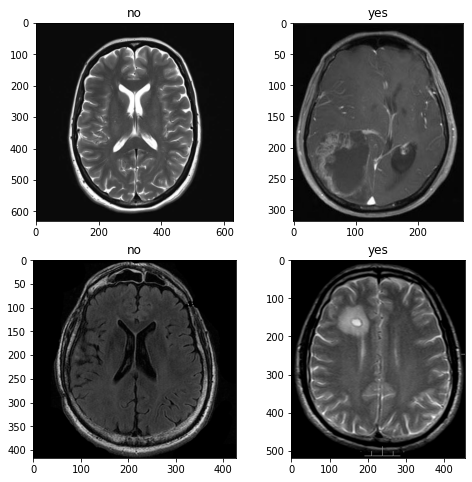

In [59]:
sample_images = [train_path + '/' + '/'.join(img) for img in train_df.sample(4)[['class_id', 'filename']].values.tolist()]
_, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for image, ax in zip(sample_images, axs):
    ax.imshow(plt.imread(image))
    ax.set_title(image.split('/')[-2])
plt.show()

In [60]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15
)

test_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator()

In [61]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='binary'
)

Found 202 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


### Transfer Learning

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task such as Image Net Data set. The weights of the pre trained model can be ustilse for the classification of other task. You don't have to train your model from scratch.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model and can be use for other different task of classification. The feature map of Pre Trained Model can be used. 

In [62]:
from tensorflow.keras.applications import ResNet50

model = ResNet50(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

In [63]:
for layers in model.layers:
    layers.trainable = False

In [64]:
from keras.layers import Dropout

x = Flatten()(model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = keras.Model(model.input, x)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

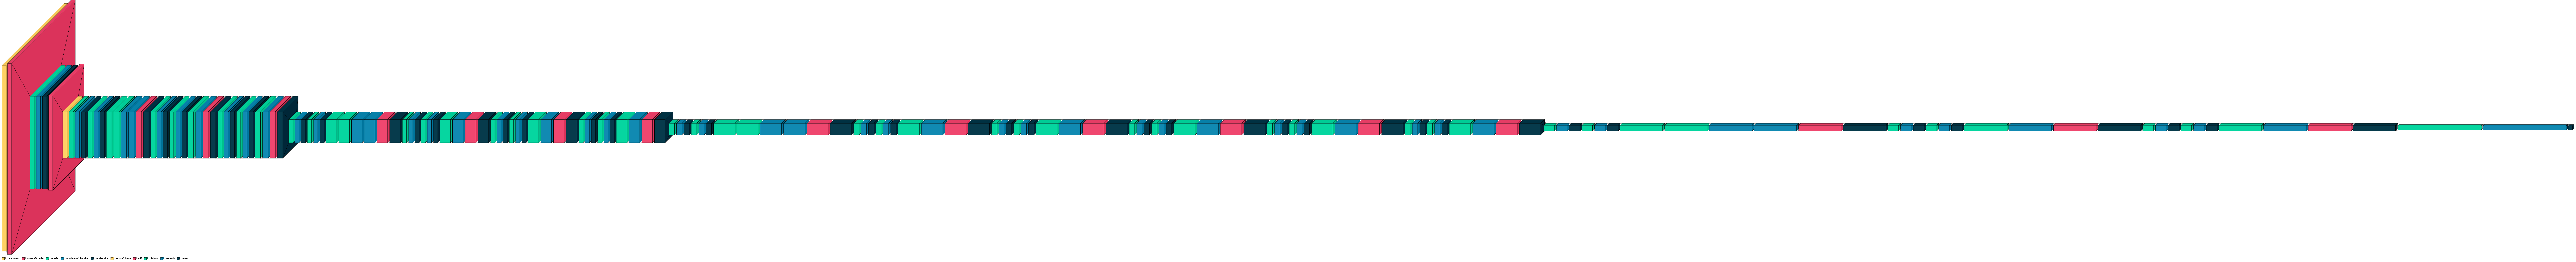

In [65]:
import visualkeras
visualkeras.layered_view(model, legend=True) 

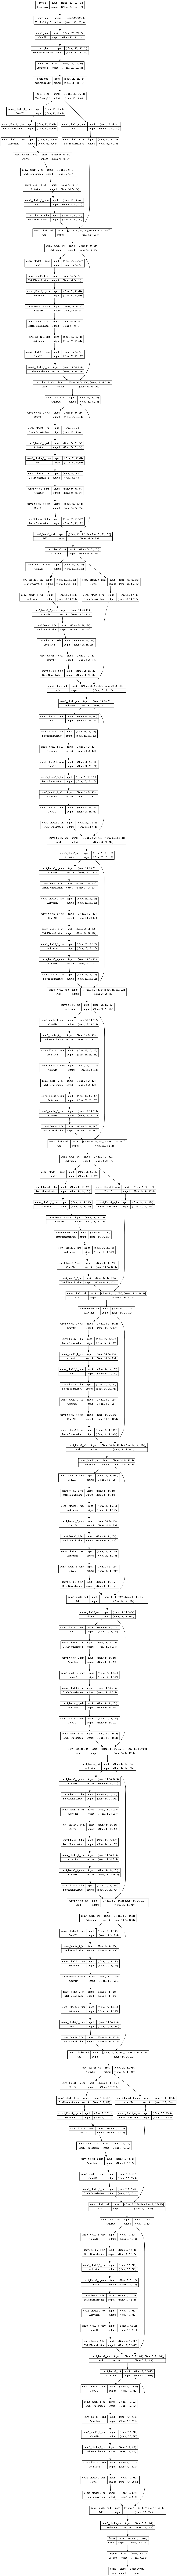

In [66]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='conv_net.png', show_shapes=True, show_layer_names=True)
Image(filename='conv_net.png')

In [67]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
model_checkpoint = ModelCheckpoint('output/tumor_model.h5', monitor='val_accuracy', mode='max')

#### Train Model

In [68]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=150,
    verbose=1,
    callbacks=[model_checkpoint, early_stopping]
)

C:\Users\thaku\AppData\Local\Temp\ipykernel_37288\2696929340.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/150
7/7 [==============================] - 13s 521ms/step - loss: 3.5760 - accuracy: 0.5396 - val_loss: 2.3843 - val_accuracy: 0.7500
Epoch 2/150
7/7 [==============================] - 2s 348ms/step - loss: 1.3243 - accuracy: 0.7970 - val_loss: 1.1471 - val_accuracy: 0.8750
Epoch 3/150
7/7 [==============================] - 2s 305ms/step - loss: 1.3747 - accuracy: 0.8614 - val_loss: 1.2482 - val_accuracy: 0.8750
Epoch 4/150
7/7 [==============================] - 2s 326ms/step - loss: 0.7617 - accuracy: 0.8911 - val_loss: 1.3442 - val_accuracy: 0.8750
Epoch 5/150
7/7 [==============================] - 2s 309ms/step - loss: 0.9134 - accuracy: 0.8515 - val_loss: 1.4139 - val_accuracy: 0.7917
Epoch 6/150
7/7 [==============================] - 2s 372ms/step - loss: 0.6847 - accuracy: 0.8960 - val_loss: 1.4736 - val_accuracy: 0.8333
Epoch 7/150
7/7 [==============================] - 2s 302ms/step - loss: 0.6210 - accuracy: 0.8861 - val_loss: 1.3488 - val_accuracy: 0.8333
Epoch 8/150


### Plotting History

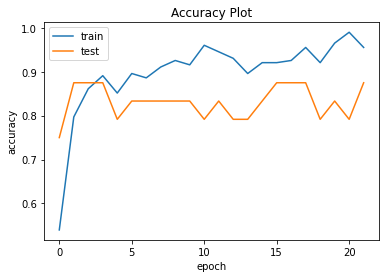

In [69]:
hist = history.history

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('Accuracy Plot')
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

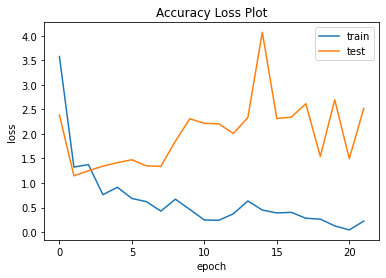

In [70]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Accuracy Loss Plot')
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Model Evaluation

In [73]:
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_accuracy * 100.0))

1/1 [==============================] - 1s 544ms/step - loss: 3.1599 - accuracy: 0.7778
Loss: 315.995
Accuracy: 77.778


### Classifiaction Report

In [77]:
from sklearn.metrics import classification_report

y_val = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred))

1/1 [==============================] - 0s 94ms/step
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        11
           1       0.00      0.00      0.00        16

    accuracy                           0.41        27
   macro avg       0.20      0.50      0.29        27
weighted avg       0.17      0.41      0.24        27



In [78]:
class_indices = test_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

filenames = test_generator.filenames
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

,filename,actual,predicted,Same
0,no\15 no.jpg,no,no,True
1,no\32 no.jpg,no,no,True
2,no\35 no.jpg,no,no,True
3,no\36 no.jpg,no,no,True
4,no\6 no.jpg,no,no,True
5,no\N26.JPG,no,no,True
6,no\no 10.jpg,no,no,True
7,no\no 5.jpeg,no,no,True
8,no\no 9.png,no,no,True
9,no\no 92.jpg,no,no,True


In [79]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

### Prediction Comparison

In [106]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

image_size = 224

def read_image(path):
    image = load_img(path, color_mode='rgb', target_size=(image_size, image_size))
    image = img_to_array(image)
    image = image/255
    
    return image


def display_images(temp_df, rows=3, cols=3):
    pred_images = ['brain_tumor_dataset\\' + img for img in temp_df['filename'].values.tolist()]
    label_data = [f'actual: {data[0]}, predicted: {data[1]}' for data in temp_df[['actual', 'predicted']].values.tolist()]
    _, axs = plt.subplots(rows, cols, figsize=(8, 8))
    axs = axs.flatten()
    for image, label, ax in zip(pred_images, label_data, axs):
        ax.imshow(plt.imread(image))
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

### Correctly Classified

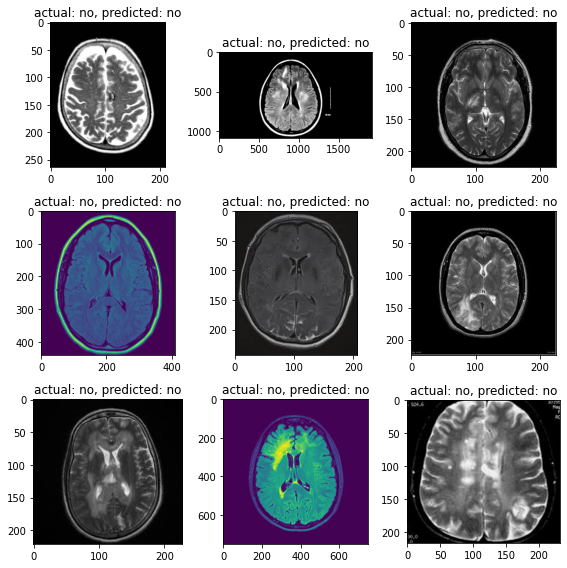

In [107]:
display_images(val_df[val_df['Same']==True])

### Miss Classified

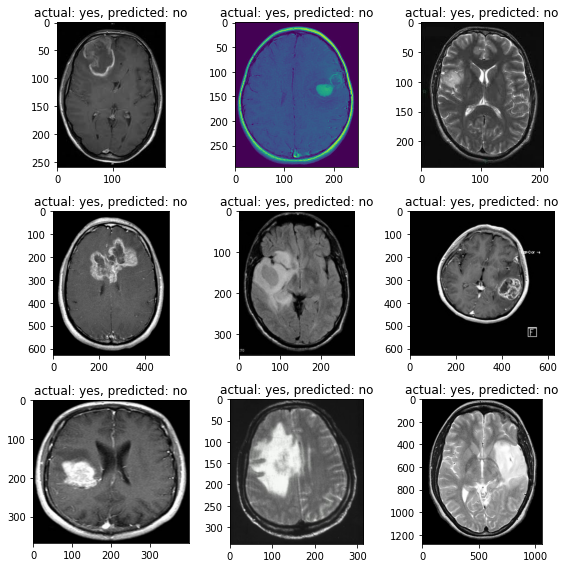

In [108]:
display_images(val_df[val_df['Same']!=True])

### Confusion Matrix

In [113]:
import itertools
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_val, y_pred=y_pred)

In [114]:
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[11  0]
 [16  0]]


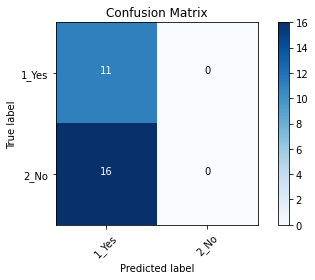

In [115]:
cm_plot_labels = ['1_Yes', '2_No']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')